# Derive mask for ocean grid boxes for ICON-NWP runs based on external parameter data

We build a time-constant mask of ocean grid cells using the variable 'FR\_LAND' of the external parameter file. We do so for all horizontal resolutions ranging from 80km ot 2.5km, where we work on the interpolated 1deg x 1deg longitude-latitude grid. We classify a grid cell as ocean only if 'FR\_LAND'==0, i.e., we exclude cells with only partial ocean coverage. It should also be noted that sea-ice cover is not taken into account here as it is not part of the external parameter but of the time dependent model output. Therefore, a cell classified as ocean can be covered by sea ice, and so is not necessarily an open ocean cell.

We first construct an ocean mask for each resolution individually and then a joint open mask. The joint open mask is constructed in a conservative manner: an cell is classified as ocean only if it is classified as ocean for all resolutions. Finally, the joint mask is saved to a netcdf file.

The notebook is written for Mistral at DKRZ.

In [1]:
import numpy as np
import xarray as xr

Construct an ocean mask for each resolution.

In [2]:
mask_list=[]
for res in ['80000', '40000', '20000', '10000', '5000', '2500']:
    mask = ( xr.open_dataset('/work/bb1018/b380459/NAWDEX/extpar/'
                           'extpar_icon-grid_nawdex_78w40e23n80n_R'+res+'m_bitmap.gridr1x1.nc')
           ['FR_LAND'] )
    mask_list.append(mask)
    del mask

Construct the joint ocean mask: only count points where all resolutions have 'FR_LAND'==0. Also rename to oceanmask.

In [3]:
jointmask = mask_list[0]
for mask in mask_list[1:]:
    jointmask = xr.ufuncs.maximum(jointmask, mask).compute()

jointmask = 1.0 - xr.ufuncs.ceil(jointmask)    

jointmask = jointmask.rename('oceanmask')

Save joint mask to netcdf file.

In [4]:
jointmask.to_netcdf('/work/bb1018/nawdex-hackathon_pp/jointoceanmask/jointoceanmask_80km-to-2km.gridr1x1.nc')

Plot joint mask for illustration.

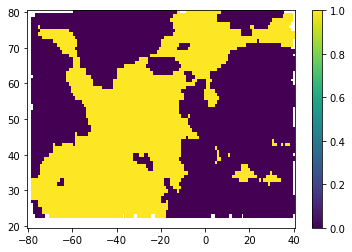

In [5]:
import matplotlib.pyplot as plt

lons = np.hstack([jointmask.lon.values-0.5, jointmask.lon.values[-1]+0.5])
lats = np.hstack([jointmask.lat.values-0.5, jointmask.lat.values[-1]+0.5])

plt.pcolormesh(lons, lats, jointmask)
plt.colorbar()